In [1]:
# https://github.com/gkhayes/author_attribution/blob/master/analysis.ipynb

In [147]:
# Import packages
import numpy as np
import pandas as pd
import chardet
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
import string
import time

# Display plots inline
%matplotlib inline

import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, make_scorer, confusion_matrix
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.preprocessing import LabelBinarizer
from sklearn.svm import SVC

from keras.models import Model
from keras.layers import Input, Dense, Flatten, Dropout, Embedding
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers.merge import concatenate
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.text import one_hot
from keras.callbacks import ModelCheckpoint 

from scipy import sparse, stats

In [209]:
data = pd.read_json("../../data/related_data_rm_duplicacy_final.json")
data = data[["content","author_name"]]
print(data.head(2))

                                             content      author_name
0  Stephen OrbanFollowJun 2, 2016·4 min readA Hyb...    Stephen Orban
1  Leo KyrpychenkoFollowDec 6, 2014·6 min readClo...  Leo Kyrpychenko


In [211]:
len(data.author_name.unique())

13217

In [149]:
n = 10
top_10_authors = data['author_name'].value_counts()[:n].index.tolist()
top_10_authors

['Alexis MP',
 'Netflix Technology Blog',
 'Ethan Siegel',
 'Nick Babich',
 'Muzli',
 'ConsenSys',
 'ExtremeTech',
 'Carlos E. Perez',
 'Bhargav Bachina',
 'Adobe Creative Cloud']

In [150]:
data = data[data['author_name'].isin(top_10_authors)]
data.shape

(1233, 2)

In [151]:
set(data['author_name'].tolist())

{'Adobe Creative Cloud',
 'Alexis MP',
 'Bhargav Bachina',
 'Carlos E. Perez',
 'ConsenSys',
 'Ethan Siegel',
 'ExtremeTech',
 'Muzli',
 'Netflix Technology Blog',
 'Nick Babich'}

In [152]:
# Create feature (text) and label (author) lists
text = list(data['content'].values)
author = list(data['author_name'].values)

print("The author dataset contains {} datapoints.".format(len(text)))

The author dataset contains 1233 datapoints.


In [153]:
# Create word count and character count lists
word_count = []
char_count = []

for i in range(len(text)):
    word_count.append(len(text[i].split()))
    char_count.append(len(text[i]))

# Convert lists to numpy arrays
word_count = np.array(word_count)
char_count = np.array(char_count)

# Calculate average word lengths
ave_length = np.array(char_count)/np.array(word_count)

In [154]:
def get_stats(var):
    """Print summary statistics for a variable of interest.
    
    Args:
    var: array. Numpy array containing values for the variable of interest.

    Returns:
    None
    """
    print("Min:", np.min(var))
    print("Max:", np.max(var))
    print("Mean:", np.mean(var))
    print("Median", np.median(var))
    print("1st percentile", np.percentile(var, 1))
    print("95th percentile", np.percentile(var, 95))
    print("99th percentile", np.percentile(var, 99))
    print("99.5th Percentile", np.percentile(var, 99.5))
    print("99.9th Percentile", np.percentile(var, 99.9))

In [155]:
print("Word count statistics")
get_stats(word_count)

Word count statistics
Min: 19
Max: 6589
Mean: 787.4209245742093
Median 484.0
1st percentile 61.0
95th percentile 2342.3999999999987
99th percentile 3506.0800000000004
99.5th Percentile 3953.359999999998
99.9th Percentile 6419.384000000013


/Users/roy/miniconda3/envs/medium_project/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


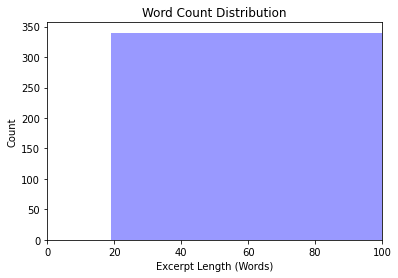

In [156]:
# Plot word count distribution
sns.distplot(word_count, kde = False, bins = 70, color = 'blue').set_title("Word Count Distribution")
plt.xlabel('Excerpt Length (Words)')
plt.ylabel('Count')
plt.xlim(0, 100)
plt.savefig("word_count.eps")

In [157]:
print("\nCharacter count statistics")
get_stats(char_count)


Character count statistics
Min: 180
Max: 43737
Mean: 5113.051905920519
Median 3493.0
1st percentile 398.0
95th percentile 15003.599999999995
99th percentile 22844.480000000036
99.5th Percentile 26051.35999999988
99.9th Percentile 39349.92800000006


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


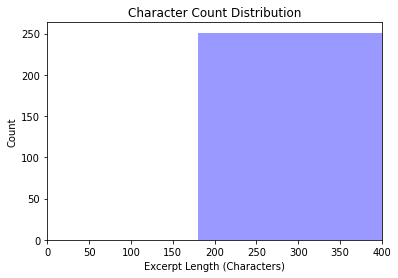

In [158]:
# Plot character count distribution
sns.distplot(char_count, kde = False, bins = 100, color = 'blue').set_title("Character Count Distribution")
plt.xlabel('Excerpt Length (Characters)')
plt.ylabel('Count')
plt.xlim(0, 400)
plt.savefig("char_count.eps")

In [159]:
print("\nAverage length statistics")
get_stats(ave_length)


Average length statistics
Min: 5.382716049382716
Max: 18.956521739130434
Mean: 6.602283826803138
Median 6.512106537530267
1st percentile 5.673458646616542
95th percentile 7.478504331489406
99th percentile 7.802253010372927
99.5th Percentile 7.915277896406563
99.9th Percentile 9.210892448512618


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


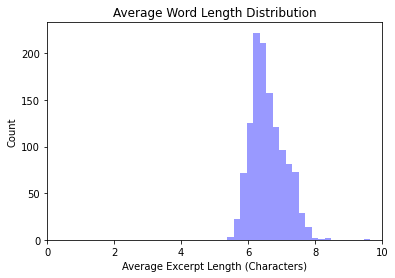

In [160]:
# Plot average excerpt length distribution
sns.distplot(ave_length, kde = False, bins = 70, color = 'blue').set_title("Average Word Length Distribution")
plt.xlabel('Average Excerpt Length (Characters)')
plt.ylabel('Count')
plt.xlim(0, 10)
plt.savefig("ave_length.eps")

In [161]:
# Create string containing all excerpts in lower case
text_string = ''

for i in range(len(text)):
    text_string += text[i].lower()

# Get character frequencies
char_cnt = Counter(text_string)
print(char_cnt)
print(len(char_cnt))


Counter({' ': 974219, 'e': 627974, 't': 463043, 'a': 406599, 'o': 397824, 'i': 381501, 'n': 360185, 's': 343954, 'r': 316312, 'l': 220487, 'c': 189620, 'h': 188611, 'd': 182423, 'u': 154921, 'm': 131487, 'p': 130313, 'g': 120518, 'f': 104806, 'y': 82994, 'w': 82881, 'b': 80447, 'v': 59515, '.': 52805, ',': 41236, 'k': 38867, 'x': 20119, '’': 11902, '-': 11359, ')': 9945, '(': 9858, ':': 9815, '0': 8962, 'z': 7871, 'q': 7839, '1': 7525, 'j': 7453, '2': 6686, '“': 4799, '”': 4729, '/': 3989, '—': 3856, '3': 2889, '?': 2134, '5': 2071, ']': 2020, '[': 2003, '4': 1938, '8': 1922, '6': 1825, '7': 1809, '9': 1779, '·': 1242, '!': 1225, '"': 1173, '#': 837, '…': 807, '‘': 727, ';': 705, '=': 673, '%': 536, '_': 520, '&': 472, '|': 367, '>': 348, '+': 341, '<': 295, '$': 260, '–': 220, '{': 215, '}': 212, 'á': 206, '@': 198, 'ó': 181, 'é': 168, "'": 137, 'í': 135, '*': 113, '™': 72, '\u200b': 68, '~': 54, 'λ': 52, 'š': 45, 'ú': 43, 'ñ': 37, '✈': 36, '`': 29, '─': 28, 'ø': 27, '\u200a': 23, 'ł'

In [162]:
# Get character count dictionary keys
print(list(char_cnt.keys()))

['n', 'e', 't', 'f', 'l', 'i', 'x', ' ', 'c', 'h', 'o', 'g', 'y', 'b', 'w', 'j', 'a', '1', '5', ',', '2', '0', '3', '·', '6', 'm', 'r', 'd', 's', 'v', 'p', 'z', 'u', '.', ':', 'k', '/', '-', 'q', '+', '#', '[', ']', '(', ')', '4', '&', '7', '“', '”', '×', '’', '?', '{', '=', '@', "'", '}', '"', '—', '<', '>', '_', ';', '8', '9', '$', '…', '!', '%', '|', '–', '→', '~', 'μ', '͝', 'ˌ', 'ā', 'ə', '*', '💻', '\xa0', 'é', '‘', 'ð', 'ξ', '»', '⊙', 'ω', '\\', 'ä', 'ü', '←', 'ë', '👇', '\x80', '\x99', 'â', '\x93', '\u200b', '\u200a', 'ć', '❤', '️', 'с', '🚀', '🐇', '́', '̂', '●', '💙', '📚', '🛠', '👊', '├', '─', '│', '└', '🤷', '🏼', '\u200d', '♀', '👵', '🏻', '✨', '🤝', '📢', '🐱', '📊', '📈', '🤯', '✍', '☕', '🐾', '💪', '🌸', '☝', '✈', '°', 'í', 'č', '🚣', '™', 'á', 'š', 'ň', 'ń', '／', 'ᴧ', 'ø', 'ł', '∆', '彩', '云', '•', '⋈', 'ö', '➔', '✌', '⍨', '®', '⅓', '`', 'ï', '^', 'î', '²', '¹', 'ã', '†', '横', '下', '太', '孫', 'た', 'い', 'そ', 'ん', 'の', 'ペ', 'ク', 'チ', 'ョ', 'ン', 'を', '連', 'れ', '北', '漢', 'プ', 'ッ', 'カ', '山', 'に', '

In [163]:
# Remove invalid character from text
text = [excerpt.replace('\xa0', '') for excerpt in text]

In [164]:
# Verify character has been removed
unusual_text = []

for i in range(len(text)):
    for j in text[i]:
        if j == '\xa0':
            unusual_text.append(i)
        
unusual_text = list(set(unusual_text))
 
print('There are', str(len(unusual_text)), 'texts containing the invalid character.')

There are 0 texts containing the invalid character.


In [165]:
# Count texts containing white space blocks
ctr = 0
for excerpt in text:
    if "  " in excerpt:
        ctr += 1

print('There are', ctr, 'excerpts containing blocks of white space.')

There are 24 excerpts containing blocks of white space.


In [166]:
# Remove blocks of white space
new_text = []

for excerpt in text:
    while "  " in excerpt:
        excerpt = excerpt.replace("  "," ")
    new_text.append(excerpt)

text = new_text
print(len(text))

1233


In [167]:
ctr = 0
for excerpt in text:
    if "  " in excerpt:
        ctr += 1

print('There are', ctr, 'excerpts containing blocks of white space.')

There are 0 excerpts containing blocks of white space.


In [168]:
normed_text = []

for i in range(len(text)):
    new = text[i].lower()
    new = new.translate(str.maketrans('','', string.punctuation))
    new = new.replace('“', '').replace('”', '')
    normed_text.append(new)
    
print(normed_text[0:5])    
print(len(normed_text))

['netflix technology blogfollowjan 15 2013·6 min readsaveoptimizing the netflix apiby ben christensenabout a year ago the netflix api team began redesigning the api to improve performance and enable ui engineering teams within netflix to optimize client applications for specific devices philosophies of the redesign were introduced in a previous post about embracing the differences between the different clients and devicesthis post is part one of a series on the architecture of our redesigned apigoalswe had multiple goals in creating this system as followsreduce chattinessone of the key drivers in pursuing the redesign in the first place was to reduce the chatty nature of our clientserver communication which could be hindering the overall performance of our device implementations due to the generic and granular nature of the original restbased netflix api each call returns only a portion of functionality for a given user experience requiring client applications to make multiple calls th

In [169]:
text_train, text_test, author_train, author_test = train_test_split(normed_text, author, test_size = 0.2, random_state = 5)

In [170]:
# Check shapes of created datasets
print(np.shape(text_train))
print(np.shape(text_test))
print(np.shape(author_train))
print(np.shape(author_test))

(986,)
(247,)
(986,)
(247,)


In [171]:
set(list(author_test))

{'Adobe Creative Cloud',
 'Alexis MP',
 'Bhargav Bachina',
 'Carlos E. Perez',
 'ConsenSys',
 'Ethan Siegel',
 'ExtremeTech',
 'Muzli',
 'Netflix Technology Blog',
 'Nick Babich'}

In [172]:
def create_n_grams(excerpt_list, n, vocab_size, seq_size):
    """Create a list of n-gram sequences
    
    Args:
    excerpt_list: list of strings. List of normalized text excerpts.
    n: int. Length of n-grams.
    vocab_size: int. Size of n-gram vocab (used in one-hot encoding)
    seq_size: int. Size of n-gram sequences
    
    Returns:
    n_gram_array: array. Numpy array of one-hot encoded n-grams.
    """
    n_gram_list = []

    for excerpt in excerpt_list:
        # Remove spaces
        excerpt = excerpt.replace(" ", "")

        # Extract n-grams
        n_grams = [excerpt[i:i + n] for i in range(len(excerpt) - n + 1)]

        # Convert to a single string with spaces between n-grams
        new_string = " ".join(n_grams)

        # One hot encode
        hot = one_hot(new_string, round(vocab_size*1.3))

        # Pad hot if necessary
        hot_len = len(hot)
        if hot_len >= seq_size:
            hot = hot[0:seq_size]
        else:
            diff = seq_size - hot_len
            extra = [0]*diff
            hot = hot + extra

        n_gram_list.append(hot)
    
    n_gram_array = np.array(n_gram_list)
    
    return n_gram_array

In [173]:
def get_vocab_size(excerpt_list, n, seq_size):
    """Calculate size of n-gram vocab
    
    Args:
    excerpt_list: list of strings. List of normalized text excerpts.
    n: int. Length of n-grams.
    seq_size: int. Size of n-gram sequences
    
    Returns:
    vocab_size: int. Size of n-gram vocab.
    """
    n_gram_list = []

    for excerpt in excerpt_list:
        # Remove spaces
        excerpt = excerpt.replace(" ", "")

        # Extract n-grams           
        n_grams = [excerpt[i:i + n] for i in range(len(excerpt) - n + 1)]

        # Create list of n-grams
        gram_len = len(n_grams)
        if gram_len >= seq_size:
            n_grams = n_grams[0:seq_size]
        else:
            diff = seq_size - gram_len
            extra = [0]*diff
            n_grams = n_grams + extra
        
        n_gram_list.append(n_grams)
    
    # Flatten n-gram list
    n_gram_list = list(np.array(n_gram_list).flat)
    
    # Calculate vocab size
    n_gram_cnt = Counter(n_gram_list)
    vocab_size = len(n_gram_cnt)
    
    return vocab_size

In [174]:
# Determine vocab sizes

for i in range(1, 4):
    vocab_size = get_vocab_size(text_train, i, 350)
    print('Vocab size for n =', i, 'is:', vocab_size)

Vocab size for n = 1 is: 109
Vocab size for n = 2 is: 1577
Vocab size for n = 3 is: 11562


In [175]:
# Create n-gram lists
gram1_train = create_n_grams(text_train, 1, 51, 350)
gram2_train = create_n_grams(text_train, 2, 966, 350)
gram3_train = create_n_grams(text_train, 3, 9521, 350)

gram1_test = create_n_grams(text_test, 1, 51, 350)
gram2_test = create_n_grams(text_test, 2, 966, 350)
gram3_test = create_n_grams(text_test, 3, 9521, 350)

print(np.shape(gram1_train))
print(np.shape(gram2_train))
print(np.shape(gram3_train))

print(np.shape(gram1_test))
print(np.shape(gram2_test))
print(np.shape(gram3_test))

(986, 350)
(986, 350)
(986, 350)
(247, 350)
(247, 350)
(247, 350)


In [176]:
# Determine maximum value of n-gram encodings (this is used to set the CNN embedding dimension)
max_1gram = np.max(gram1_train)
max_2gram = np.max(gram2_train)
max_3gram = np.max(gram3_train)

print('Maximum encoding value for 1-grams is: ', max_1gram)
print('Maximum encoding value for 2-grams is: ', max_2gram)
print('Maximum encoding value for 3-grams is: ', max_3gram)

Maximum encoding value for 1-grams is:  64
Maximum encoding value for 2-grams is:  1255
Maximum encoding value for 3-grams is:  12376


In [177]:
def process_data(excerpt_list):
    """Stem data, remove stopwords and split into word lists
    
    Args:
    excerpt_list: list of strings. List of normalized text excerpts.
    
    Returns:
    processed: list of strings. List of lists of processed text excerpts (stemmed and stop words removed).
    """
    stop_words = set(stopwords.words('english'))
    porter = PorterStemmer()
    
    processed = []
    
    for excerpt in excerpt_list:
        new = excerpt.split()
        word_list = [porter.stem(w) for w in new if not w in stop_words]
        word_list = " ".join(word_list)
        processed.append(word_list)
    
    return processed

In [178]:
# Process data subsets
processed_train = process_data(text_train)
processed_test = process_data(text_test)

print(processed_train[0:5])

['muzlifollowjun 14 2016·3 min readsavemoviecinema ui inspirationvia muzli design inspirationday 085 — cinema applic paul flaviu nechitamovi applic ui ricardo salazarmovi storylin david paciliomedia librari julia khusainovamovi applic alex banaganetflix rework viktor hoftecinema applic malt westedtcinema app giga tamarashvilitv show app aryana shakibaeimovi app ui sketch freebi λνøffdaili ui 025 — tv app shab majeedmovi applic arvinmovi card balajicinema app angelika omertheat ticket app filip marceloendur tomasz chrostekday 006 — cinema io app giovanni xucinema applic worawalunsday 85 — cinema applic benc vitariusmovi applic ananasonokko new product smart tv serega mekrukovmovi applic danielimdb design concept georg vasyagin awesomedexplor movi stream dwinawan hariwijayamovium vilém riesweb onlin serial andrej krajčirtivibu concept gülçin gümüşnetflix explor bart ebbekinkmobil version movi list like dislik movi prakhar neel sharmamovi list ionut zamfir', 'consensysfollowdec 23 2015·5 

In [179]:
# Create bag of words features
## Fit Tfidf Vectorizer
vectorizer = TfidfVectorizer(strip_accents = 'ascii', stop_words = 'english', min_df = 6)
vectorizer.fit(processed_train)

# Get size of vocabulary
print('Vocabulary size: ', len(vectorizer.vocabulary_))

# Create feature vectors
words_train = vectorizer.transform(processed_train)
words_test = vectorizer.transform(processed_test)


Vocabulary size:  4388


In [180]:
# One hot encode labels
author_lb = LabelBinarizer()

author_lb.fit(author_train)
author_train_hot = author_lb.transform(author_train)
author_test_hot = author_lb.transform(author_test)

In [181]:
# Define model architecture in keras
# Code reference: https://machinelearningmastery.com/develop-n-gram-multichannel-convolutional-neural-network-sentiment-analysis/
def define_model(input_len, output_size, vocab_size, embedding_dim, verbose = True,
                drop_out_pct = 0.25, conv_filters = 500, activation_fn = 'relu', pool_size = 2, learning = 0.0001):
    """Define n-gram CNN
    
    Args:
    input_len: int. Length of input sequences.
    output_size: int. Number of output classes.
    vocab_size: int. Maximum value of n-gram encoding.
    embedding_dim: int. Size of embedding layer.
    verbose: bool. Whether or not to print model summary.
    drop_out_pct: float. Drop-out rate.
    conv_filters: int. Number of filters in the conv layer.
    activation_fn: string. Activation function to use in the convolutional layer.
    pool_size: int. Pool size for the max pooling layer.
    learning: float. Learning rate for the model optimizer.
    
    Returns:
    model: keras model object. 
    """
    # Channel 1
    inputs1 = Input(shape = (input_len,))
    embedding1 = Embedding(vocab_size, embedding_dim)(inputs1)
    drop1 = Dropout(drop_out_pct)(embedding1)
    conv1 = Conv1D(filters = conv_filters, kernel_size = 3, activation = activation_fn)(drop1)
    pool1 = MaxPooling1D(pool_size = pool_size)(conv1)
    flat1 = Flatten()(pool1)
    
    # Channel 2
    inputs2 = Input(shape = (input_len,))
    embedding2 = Embedding(vocab_size, embedding_dim)(inputs2)
    drop2 = Dropout(drop_out_pct)(embedding2)
    conv2 = Conv1D(filters = conv_filters, kernel_size = 4, activation = activation_fn)(drop2)
    pool2 = MaxPooling1D(pool_size = pool_size)(conv2)
    flat2 = Flatten()(pool2)

    # Channel 3
    inputs3 = Input(shape = (input_len,))
    embedding3= Embedding(vocab_size, embedding_dim)(inputs3)
    drop3 = Dropout(drop_out_pct)(embedding3)
    conv3 = Conv1D(filters = conv_filters, kernel_size = 5, activation = activation_fn)(drop3)
    pool3 = MaxPooling1D(pool_size = pool_size)(conv3)
    flat3 = Flatten()(pool3)
    
    # Merge channels
    merged = concatenate([flat1, flat2, flat3])
    
    # Create output layer
    output = Dense(output_size, activation = 'softmax')(merged)
    
    # Create model
    model = Model(inputs = [inputs1, inputs2, inputs3], outputs = output)
    
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer = Adam(lr = learning), metrics=['accuracy'])
    
    if verbose:
        print(model.summary())
        
    return model

In [182]:
# Create the 1-gram model
gram1_model = define_model(350, 10, max_1gram + 1, 26)

Model: "model_19"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_60 (InputLayer)          [(None, 350)]        0           []                               
                                                                                                  
 input_61 (InputLayer)          [(None, 350)]        0           []                               
                                                                                                  
 input_62 (InputLayer)          [(None, 350)]        0           []                               
                                                                                                  
 embedding_59 (Embedding)       (None, 350, 26)      1690        ['input_60[0][0]']               
                                                                                           

/Users/roy/miniconda3/envs/medium_project/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [183]:
# Train 1-gram CNN
gram1_model.fit([gram1_train, gram1_train, gram1_train], author_train_hot, epochs=10, batch_size=32, 
                verbose = 1, validation_split = 0.2)

Epoch 1/10
25/25 [==============================] - 5s 162ms/step - loss: 2.1878 - accuracy: 0.2284 - val_loss: 2.0925 - val_accuracy: 0.3838
Epoch 2/10
25/25 [==============================] - 4s 150ms/step - loss: 1.8993 - accuracy: 0.5025 - val_loss: 1.8113 - val_accuracy: 0.5354
Epoch 3/10
25/25 [==============================] - 4s 158ms/step - loss: 1.4960 - accuracy: 0.6764 - val_loss: 1.4098 - val_accuracy: 0.8384
Epoch 4/10
25/25 [==============================] - 4s 158ms/step - loss: 0.9997 - accuracy: 0.9239 - val_loss: 0.9772 - val_accuracy: 0.8788
Epoch 5/10
25/25 [==============================] - 4s 155ms/step - loss: 0.5716 - accuracy: 0.9721 - val_loss: 0.6597 - val_accuracy: 0.8384
Epoch 6/10
25/25 [==============================] - 4s 160ms/step - loss: 0.3050 - accuracy: 0.9975 - val_loss: 0.4100 - val_accuracy: 0.9949
Epoch 7/10
25/25 [==============================] - 4s 160ms/step - loss: 0.1767 - accuracy: 0.9987 - val_loss: 0.2747 - val_accuracy: 1.0000
Epoch 

In [184]:
# Create the 2-gram model
gram2_model = define_model(350, 10, max_2gram + 1, 300)

Model: "model_20"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_63 (InputLayer)          [(None, 350)]        0           []                               
                                                                                                  
 input_64 (InputLayer)          [(None, 350)]        0           []                               
                                                                                                  
 input_65 (InputLayer)          [(None, 350)]        0           []                               
                                                                                                  
 embedding_62 (Embedding)       (None, 350, 300)     376800      ['input_63[0][0]']               
                                                                                           

In [185]:
# Train 2-gram CNN
gram2_model.fit([gram2_train, gram2_train, gram2_train], author_train_hot, epochs=10, batch_size=32, 
                verbose = 1, validation_split = 0.2)

Epoch 1/10
25/25 [==============================] - 17s 622ms/step - loss: 2.0753 - accuracy: 0.3706 - val_loss: 1.8189 - val_accuracy: 0.6212
Epoch 2/10
25/25 [==============================] - 17s 668ms/step - loss: 1.3789 - accuracy: 0.8122 - val_loss: 1.2471 - val_accuracy: 0.7576
Epoch 3/10
25/25 [==============================] - 22s 896ms/step - loss: 0.6960 - accuracy: 0.9721 - val_loss: 0.5997 - val_accuracy: 1.0000
Epoch 4/10
25/25 [==============================] - 17s 702ms/step - loss: 0.2681 - accuracy: 0.9987 - val_loss: 0.3034 - val_accuracy: 1.0000
Epoch 5/10
25/25 [==============================] - 17s 678ms/step - loss: 0.1128 - accuracy: 0.9987 - val_loss: 0.1872 - val_accuracy: 1.0000
Epoch 6/10
25/25 [==============================] - 17s 698ms/step - loss: 0.0603 - accuracy: 0.9987 - val_loss: 0.1275 - val_accuracy: 1.0000
Epoch 7/10
25/25 [==============================] - 16s 644ms/step - loss: 0.0380 - accuracy: 0.9987 - val_loss: 0.0996 - val_accuracy: 1.0000

In [186]:
# Create the 3-gram model
gram3_model = define_model(350, 10, max_3gram + 1, 600)

Model: "model_21"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_66 (InputLayer)          [(None, 350)]        0           []                               
                                                                                                  
 input_67 (InputLayer)          [(None, 350)]        0           []                               
                                                                                                  
 input_68 (InputLayer)          [(None, 350)]        0           []                               
                                                                                                  
 embedding_65 (Embedding)       (None, 350, 600)     7426200     ['input_66[0][0]']               
                                                                                           

In [187]:
# Train 3-gram CNN
gram3_model.fit([gram3_train, gram3_train, gram3_train], author_train_hot, epochs=10, batch_size=32, 
                verbose = 1, validation_split = 0.2)

Epoch 1/10
25/25 [==============================] - 33s 1s/step - loss: 1.9969 - accuracy: 0.4124 - val_loss: 1.6273 - val_accuracy: 0.6465
Epoch 2/10
25/25 [==============================] - 32s 1s/step - loss: 1.0929 - accuracy: 0.8744 - val_loss: 0.9692 - val_accuracy: 0.8737
Epoch 3/10
25/25 [==============================] - 32s 1s/step - loss: 0.4282 - accuracy: 0.9810 - val_loss: 0.4166 - val_accuracy: 0.9949
Epoch 4/10
25/25 [==============================] - 32s 1s/step - loss: 0.1418 - accuracy: 0.9987 - val_loss: 0.1938 - val_accuracy: 1.0000
Epoch 5/10
25/25 [==============================] - 32s 1s/step - loss: 0.0639 - accuracy: 0.9987 - val_loss: 0.1147 - val_accuracy: 1.0000
Epoch 6/10
25/25 [==============================] - 33s 1s/step - loss: 0.0365 - accuracy: 0.9987 - val_loss: 0.0885 - val_accuracy: 1.0000
Epoch 7/10
25/25 [==============================] - 31s 1s/step - loss: 0.0235 - accuracy: 1.0000 - val_loss: 0.0694 - val_accuracy: 1.0000
Epoch 8/10
25/25 [==

In [188]:
# Define grid search object
svm = SVC()
params = {'kernel': ['linear'], 'C':[1, 10, 100]}
scorer = make_scorer(accuracy_score)

grid_obj = GridSearchCV(svm, params, scoring = scorer, verbose = 50)

In [189]:
# Fit bag of words svm
np.random.seed(6)
word_svm = grid_obj.fit(words_train, author_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV 1/5; 1/3] START C=1, kernel=linear..........................................
[CV 1/5; 1/3] END ...........C=1, kernel=linear;, score=0.970 total time=   0.9s
[CV 2/5; 1/3] START C=1, kernel=linear..........................................
[CV 2/5; 1/3] END ...........C=1, kernel=linear;, score=0.959 total time=   0.9s
[CV 3/5; 1/3] START C=1, kernel=linear..........................................
[CV 3/5; 1/3] END ...........C=1, kernel=linear;, score=0.980 total time=   0.9s
[CV 4/5; 1/3] START C=1, kernel=linear..........................................
[CV 4/5; 1/3] END ...........C=1, kernel=linear;, score=0.949 total time=   0.9s
[CV 5/5; 1/3] START C=1, kernel=linear..........................................
[CV 5/5; 1/3] END ...........C=1, kernel=linear;, score=0.980 total time=   0.9s
[CV 1/5; 2/3] START C=10, kernel=linear.........................................
[CV 1/5; 2/3] END ..........C=10, kernel=linear;,

In [190]:
print(word_svm.best_estimator_)

SVC(C=10, kernel='linear')


In [191]:
print(word_svm.cv_results_)

{'mean_fit_time': array([0.7679718 , 0.76773505, 0.74999838]), 'std_fit_time': array([0.02291049, 0.01466205, 0.01988517]), 'mean_score_time': array([0.12433572, 0.12320771, 0.12327294]), 'std_score_time': array([0.00208994, 0.00370529, 0.00124659]), 'param_C': masked_array(data=[1, 10, 100],
             mask=[False, False, False],
       fill_value='?',
            dtype=object), 'param_kernel': masked_array(data=['linear', 'linear', 'linear'],
             mask=[False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'C': 1, 'kernel': 'linear'}, {'C': 10, 'kernel': 'linear'}, {'C': 100, 'kernel': 'linear'}], 'split0_test_score': array([0.96969697, 0.96969697, 0.96969697]), 'split1_test_score': array([0.95939086, 0.95431472, 0.95431472]), 'split2_test_score': array([0.97969543, 0.98477157, 0.98477157]), 'split3_test_score': array([0.94923858, 0.95939086, 0.95939086]), 'split4_test_score': array([0.97969543, 0.98477157, 0.97461929]), 'mean_test_score': arra

In [192]:
# Define model architecture in keras
# Code reference: https://machinelearningmastery.com/develop-n-gram-multichannel-convolutional-neural-network-sentiment-analysis/
def define_model2(input_len, output_size, vocab_size, embedding_dim, verbose = True,
                drop_out_pct = 0.25, conv_filters = 500, activation_fn = 'relu', pool_size = 2, learning = 0.0001):
    """Define n-gram CNN
    
    Args:
    input_len: int. Length of input sequences.
    output_size: int. Number of output classes.
    vocab_size: int. Maximum value of n-gram encoding.
    embedding_dim: int. Size of embedding layer.
    verbose: bool. Whether or not to print model summary.
    drop_out_pct: float. Drop-out rate.
    conv_filters: int. Number of filters in the conv layer.
    activation_fn: string. Activation function to use in the convolutional layer.
    pool_size: int. Pool size for the max pooling layer.
    learning: float. Learning rate for the model optimizer.
    
    Returns:
    model: keras model object. 
    """
    # Channel 1
    inputs1 = Input(shape = (input_len,))
    embedding1 = Embedding(vocab_size, embedding_dim)(inputs1)
    drop1 = Dropout(drop_out_pct)(embedding1)
    conv1 = Conv1D(filters = conv_filters, kernel_size = 3, activation = activation_fn)(drop1)
    pool1 = MaxPooling1D(pool_size = pool_size)(conv1)
    flat1 = Flatten()(pool1)
    
    # Channel 2
    inputs2 = Input(shape = (input_len,))
    embedding2 = Embedding(vocab_size, embedding_dim)(inputs2)
    drop2 = Dropout(drop_out_pct)(embedding2)
    conv2 = Conv1D(filters = conv_filters, kernel_size = 4, activation = activation_fn)(drop2)
    pool2 = MaxPooling1D(pool_size = pool_size)(conv2)
    flat2 = Flatten()(pool2)

    # Channel 3
    inputs3 = Input(shape = (input_len,))
    embedding3= Embedding(vocab_size, embedding_dim)(inputs3)
    drop3 = Dropout(drop_out_pct)(embedding3)
    conv3 = Conv1D(filters = conv_filters, kernel_size = 5, activation = activation_fn)(drop3)
    pool3 = MaxPooling1D(pool_size = pool_size)(conv3)
    flat3 = Flatten()(pool3)
    
    # Channel 4
    inputs4 = Input(shape = (input_len,))
    embedding4 = Embedding(vocab_size, embedding_dim)(inputs4)
    drop4 = Dropout(drop_out_pct)(embedding4)
    conv4 = Conv1D(filters = conv_filters, kernel_size = 6, activation = activation_fn)(drop4)
    pool4 = MaxPooling1D(pool_size = pool_size)(conv4)
    flat4 = Flatten()(pool4)
    
    # Merge channels
    merged = concatenate([flat1, flat2, flat3, flat4])
    
    # Create output layer
    output = Dense(output_size, activation = 'softmax')(merged)
    
    # Create model
    model = Model(inputs = [inputs1, inputs2, inputs3, inputs4], outputs = output)
    
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer = Adam(lr = learning), metrics=['accuracy'])
    
    if verbose:
        print(model.summary())
        
    return model

In [193]:
# Create the 3-gram model
gram3_model2 = define_model2(350, 10, max_3gram + 1, 600)

Model: "model_22"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_69 (InputLayer)          [(None, 350)]        0           []                               
                                                                                                  
 input_70 (InputLayer)          [(None, 350)]        0           []                               
                                                                                                  
 input_71 (InputLayer)          [(None, 350)]        0           []                               
                                                                                                  
 input_72 (InputLayer)          [(None, 350)]        0           []                               
                                                                                           

/Users/roy/miniconda3/envs/medium_project/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [194]:
# Train 3-gram CNN
gram3_model2.fit([gram3_train, gram3_train, gram3_train, gram3_train], author_train_hot, epochs=5, batch_size=32, 
                verbose = 1, validation_split = 0.2)

Epoch 1/5
25/25 [==============================] - 44s 2s/step - loss: 1.9154 - accuracy: 0.4569 - val_loss: 1.4739 - val_accuracy: 0.7071
Epoch 2/5
25/25 [==============================] - 44s 2s/step - loss: 0.8471 - accuracy: 0.9137 - val_loss: 0.6757 - val_accuracy: 1.0000
Epoch 3/5
25/25 [==============================] - 45s 2s/step - loss: 0.2652 - accuracy: 0.9987 - val_loss: 0.2740 - val_accuracy: 1.0000
Epoch 4/5
25/25 [==============================] - 45s 2s/step - loss: 0.0855 - accuracy: 0.9987 - val_loss: 0.1548 - val_accuracy: 1.0000
Epoch 5/5
25/25 [==============================] - 45s 2s/step - loss: 0.0412 - accuracy: 0.9987 - val_loss: 0.1166 - val_accuracy: 1.0000


In [195]:
# Define function for plotting normalized confusion matrix
# Code reference 1: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
# Code reference 2: https://stackoverflow.com/questions/35572000/how-can-i-plot-a-confusion-matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    
    Args:
    cm: matrix. Confusion matrix for plotting.
    classes: list. List of class labels.
    normalize: bool. Whether or not to normalize the confusion matrix.
    title: string. Title for plot.
    cmap: color map. Color scheme for plot.
    
    Returns:
    None
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
       
    df_cm = pd.DataFrame(cm, index = classes,
                  columns = classes)
    sns.heatmap(df_cm, annot=True, cmap = cmap)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.title(title)

In [202]:
# Fit and evaluate Model 1 (3-gram CNN)

t0 = time.time()

# Fit model
model1 = define_model(350, 10, max_3gram + 1, 600)
model1.fit([gram3_train, gram3_train, gram3_train], author_train_hot, epochs=5, batch_size=32, 
           verbose = 1, validation_split = 0.2)
t1 = time.time()

# Predict values for test set
author_pred1 = model1.predict([gram3_test, gram3_test, gram3_test])

t2 = time.time()

# Reverse one-hot encoding of labels
author_pred1 = author_lb.inverse_transform(author_pred1)

# Evaluate
accuracy = accuracy_score(author_test, author_pred1)
precision, recall, f1, support = score(author_test, author_pred1)
ave_precision = np.average(precision, weights = support/np.sum(support))
ave_recall = np.average(recall, weights = support/np.sum(support))
ave_f1 = np.average(f1, weights = support/np.sum(support))
confusion = confusion_matrix(author_test, author_pred1, labels = list(set(author_test)))
    
print("Accuracy:", accuracy)
print("Ave. Precision:", ave_precision)
print("Ave. Recall:", ave_recall)
print("Ave. F1 Score:", ave_f1)
print("Training Time:", (t1 - t0), "seconds")
print("Prediction Time:", (t2 - t1), "seconds")
print("Confusion Matrix:\n", confusion)

Model: "model_26"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_82 (InputLayer)          [(None, 350)]        0           []                               
                                                                                                  
 input_83 (InputLayer)          [(None, 350)]        0           []                               
                                                                                                  
 input_84 (InputLayer)          [(None, 350)]        0           []                               
                                                                                                  
 embedding_81 (Embedding)       (None, 350, 600)     7426200     ['input_82[0][0]']               
                                                                                           

/Users/roy/miniconda3/envs/medium_project/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


25/25 [==============================] - 31s 1s/step - loss: 2.0227 - accuracy: 0.3490 - val_loss: 1.6401 - val_accuracy: 0.6869
Epoch 2/5
25/25 [==============================] - 31s 1s/step - loss: 1.0911 - accuracy: 0.9353 - val_loss: 0.9072 - val_accuracy: 0.8737
Epoch 3/5
25/25 [==============================] - 31s 1s/step - loss: 0.4039 - accuracy: 0.9987 - val_loss: 0.4050 - val_accuracy: 0.9949
Epoch 4/5
25/25 [==============================] - 35s 1s/step - loss: 0.1368 - accuracy: 0.9987 - val_loss: 0.1927 - val_accuracy: 1.0000
Epoch 5/5
25/25 [==============================] - 32s 1s/step - loss: 0.0581 - accuracy: 0.9987 - val_loss: 0.1243 - val_accuracy: 0.9949
Accuracy: 1.0
Ave. Precision: 1.0
Ave. Recall: 1.0
Ave. F1 Score: 1.0
Training Time: 159.68520307540894 seconds
Prediction Time: 2.612761974334717 seconds
Confusion Matrix:
 [[19  0  0  0  0  0  0  0  0  0]
 [ 0 19  0  0  0  0  0  0  0  0]
 [ 0  0 13  0  0  0  0  0  0  0]
 [ 0  0  0 36  0  0  0  0  0  0]
 [ 0  0  

Normalized confusion matrix
[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]


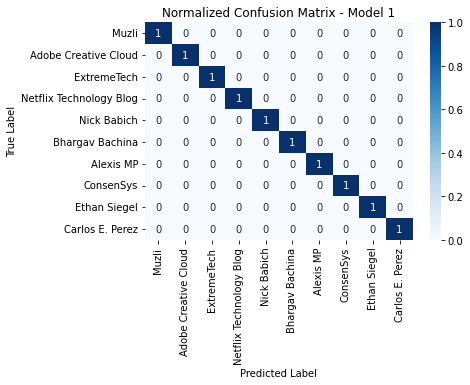

In [203]:
# Plot normalized confusion matrix
plot_confusion_matrix(confusion, classes=list(set(author_test)), \
                      normalize=True, title='Normalized Confusion Matrix - Model 1')

plt.savefig("confusion1.eps")

In [204]:
# Fit and evaluate Model 2 (Bag of words SVM)
np.random.seed(28)

t0 = time.time()

# Fit model
model2 = SVC(C = 1, kernel = 'linear')
model2.fit(words_train, author_train)

t1 = time.time()

# Predict values for test set
author_pred2 = model2.predict(words_test)

t2 = time.time()

# Evaluate
accuracy = accuracy_score(author_test, author_pred2)
precision, recall, f1, support = score(author_test, author_pred2)
ave_precision = np.average(precision, weights = support/np.sum(support))
ave_recall = np.average(recall, weights = support/np.sum(support))
ave_f1 = np.average(f1, weights = support/np.sum(support))
confusion = confusion_matrix(author_test, author_pred2, labels =  list(set(author_test)))

print("Accuracy:", accuracy)
print("Ave. Precision:", ave_precision)
print("Ave. Recall:", ave_recall)
print("Ave. F1 Score:", ave_f1)
print("Training Time:", (t1 - t0), "seconds")
print("Prediction Time:", (t2 - t1), "seconds")
print("Confusion Matrix:\n", confusion)

Accuracy: 0.9838056680161943
Ave. Precision: 0.9842606776817304
Ave. Recall: 0.9838056680161944
Ave. F1 Score: 0.983589525256853
Training Time: 0.994696855545044 seconds
Prediction Time: 0.20757818222045898 seconds
Confusion Matrix:
 [[19  0  0  0  0  0  0  0  0  0]
 [ 0 17  0  1  1  0  0  0  0  0]
 [ 0  0 13  0  0  0  0  0  0  0]
 [ 0  0  0 36  0  0  0  0  0  0]
 [ 0  0  0  0 29  0  0  0  0  0]
 [ 0  0  0  0  0 18  1  0  0  0]
 [ 0  0  0  0  0  0 39  0  0  0]
 [ 0  0  0  0  0  0  0 19  1  0]
 [ 0  0  0  0  0  0  0  0 36  0]
 [ 0  0  0  0  0  0  0  0  0 17]]


Normalized confusion matrix
[[1.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.89473684 0.         0.05263158 0.05263158 0.
  0.         0.         0.         0.        ]
 [0.         0.         1.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         1.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         1.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.94736842
  0.05263158 0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  1.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.95       0.05       0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         1.         0.        ]
 

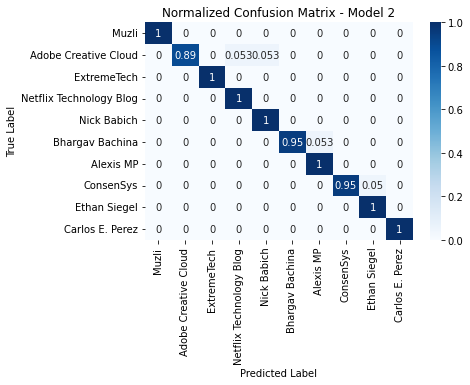

In [205]:
# Plot normalized confusion matrix
plot_confusion_matrix(confusion, classes=list(set(author_test)), \
                      normalize=True, title='Normalized Confusion Matrix - Model 2')

plt.savefig("confusion2.eps")

In [206]:
# Get benchmark statistics (random model)

# Perform 10 times and take averages

accuracy_list = []
prec_list = []
recall_list = []
f1_list = []

for i in range(10):
    # Create random predictions
    author_pred3 = np.random.choice(list(set(author_test)), len(author_test))

    # Evaluate
    accuracy = accuracy_score(author_test, author_pred3)
    precision, recall, f1, support = score(author_test, author_pred3)
    ave_precision = np.average(precision, weights = support/np.sum(support))
    ave_recall = np.average(recall, weights = support/np.sum(support))
    ave_f1 = np.average(f1, weights = support/np.sum(support))
    
    accuracy_list.append(accuracy)
    prec_list.append(ave_precision)
    recall_list.append(ave_recall)
    f1_list.append(ave_f1)

print("Accuracy:", accuracy_list, np.mean(accuracy_list), np.std(accuracy_list))
print("Ave. Precision:", prec_list, np.mean(prec_list), np.std(prec_list))
print("Ave. Recall:", recall_list, np.mean(recall_list), np.std(recall_list))
print("Ave. F1 Score:", f1_list, np.mean(f1_list), np.std(f1_list))

Accuracy: [0.0728744939271255, 0.10121457489878542, 0.08097165991902834, 0.10121457489878542, 0.11336032388663968, 0.08906882591093117, 0.06882591093117409, 0.07692307692307693, 0.10121457489878542, 0.05668016194331984] 0.08623481781376517 0.0169895832051476
Ave. Precision: [0.07881874774913825, 0.11546126596645874, 0.09175331491120965, 0.10680021952465187, 0.1271046961687053, 0.09650268062246285, 0.06557320719792117, 0.10527339966820633, 0.11012596120654158, 0.07935543161705384] 0.09767689246323497 0.017990610341126156
Ave. Recall: [0.07287449392712551, 0.10121457489878542, 0.08097165991902835, 0.10121457489878544, 0.11336032388663968, 0.08906882591093118, 0.0688259109311741, 0.07692307692307693, 0.10121457489878544, 0.05668016194331984] 0.0862348178137652 0.0169895832051476
Ave. F1 Score: [0.0724993840931063, 0.10502330424232381, 0.08199430094528896, 0.09793501614360532, 0.11449820333501644, 0.08952951961549714, 0.06477756026937836, 0.08436206630854154, 0.10095347498207059, 0.0632798

In [207]:
# Model 1 Sensitivity Testing

kf = KFold(n_splits = 3)

accuracy_list = []
prec_list = []
recall_list = []
f1_list = []
cnt = 0


for train_inds, _ in kf.split(gram3_train):
    cnt += 1
    print('Run:', cnt)
       
    # Create data subsets
    train_x = np.array([gram3_train[i] for i in train_inds])
    train_y = np.array([author_train_hot[i] for i in train_inds])
       
    # Fit model
    model1 = define_model(350, 10, max_3gram + 1, 600, verbose = False)
    model1.fit([gram3_train, gram3_train, gram3_train], author_train_hot, epochs=5, batch_size=32, verbose = 0)
    
    # Predict values for test set
    author_pred1 = model1.predict([gram3_test, gram3_test, gram3_test])
    author_pred1 = author_lb.inverse_transform(author_pred1)

    # Evaluate
    accuracy = accuracy_score(author_test, author_pred1)
    precision, recall, f1, support = score(author_test, author_pred1)
    ave_precision = np.average(precision, weights = support/np.sum(support))
    ave_recall = np.average(recall, weights = support/np.sum(support))
    ave_f1 = np.average(f1, weights = support/np.sum(support))
    
    accuracy_list.append(accuracy)
    prec_list.append(ave_precision)
    recall_list.append(ave_recall)
    f1_list.append(ave_f1)

print("Accuracy:", accuracy_list)
print("Ave. Precision:", prec_list)
print("Ave. Recall:", recall_list)
print("Ave. F1 Score:", f1_list)

Run: 1


/Users/roy/miniconda3/envs/medium_project/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Run: 2


/Users/roy/miniconda3/envs/medium_project/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Run: 3


/Users/roy/miniconda3/envs/medium_project/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Accuracy: [1.0, 1.0, 1.0]
Ave. Precision: [1.0, 1.0, 1.0]
Ave. Recall: [1.0, 1.0, 1.0]
Ave. F1 Score: [1.0, 1.0, 1.0]


In [208]:
# Model 2 sensitivity testing

kf = KFold(n_splits = 3)

accuracy_list = []
prec_list = []
recall_list = []
f1_list = []
cnt = 0

# Convert sparse matrix to array
words_train_np = words_train.toarray()

for train_inds, _ in kf.split(words_train):
    cnt += 1
    print('Run:', cnt)
       
    # Create data subsets
    train_x = np.array([words_train_np[i] for i in train_inds])
    train_y = [author_train[i] for i in train_inds]
    
    # Convert train_x back to sparse matrix
    train_x = sparse.csr_matrix(train_x)
    
    # Fit model
    model2 = SVC(C = 1, kernel = 'linear')
    model2.fit(train_x, train_y)


    # Predict values for test set
    author_pred2 = model2.predict(words_test)

    # Evaluate
    accuracy = accuracy_score(author_test, author_pred2)
    precision, recall, f1, support = score(author_test, author_pred2)
    ave_precision = np.average(precision, weights = support/np.sum(support))
    ave_recall = np.average(recall, weights = support/np.sum(support))
    ave_f1 = np.average(f1, weights = support/np.sum(support))
    
    accuracy_list.append(accuracy)
    prec_list.append(ave_precision)
    recall_list.append(ave_recall)
    f1_list.append(ave_f1)

print("Accuracy:", accuracy_list)
print("Ave. Precision:", prec_list)
print("Ave. Recall:", recall_list)
print("Ave. F1 Score:", f1_list)

Run: 1
Run: 2
Run: 3
Accuracy: [0.979757085020243, 0.9757085020242915, 0.9757085020242915]
Ave. Precision: [0.979823128507339, 0.9778820870926135, 0.9768871643365571]
Ave. Recall: [0.9797570850202432, 0.9757085020242917, 0.9757085020242915]
Ave. F1 Score: [0.9796491867449609, 0.9746959890475939, 0.9756205781145691]
